In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, random
from sklearn.metrics import confusion_matrix, classification_report

# Set seeds for reproducibility
tf.random.set_seed(123)
np.random.seed(123)
random.seed(123)

In [8]:
# Configuration parameters
# DATASET_DIR =  "/kaggle/input/bcd-new/Dataset"
DATASET_DIR =  "/kaggle/input/bcd-new-augmented/NEW"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)      # ResNet101 expects 224x224 images
INITIAL_EPOCHS = 50

In [4]:
# Load training and validation datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
print("Classes found:", train_ds.class_names)

Found 13287 files belonging to 2 classes.
Using 10630 files for training.
Found 13287 files belonging to 2 classes.
Using 2657 files for validation.
Classes found: ['Cancer', 'Non-Cancer']


In [5]:
# Calculate class weights from the training dataset
train_class_counts = [0, 0]
for _, labels in train_ds.unbatch():
    train_class_counts[int(labels.numpy())] += 1
total_train = sum(train_class_counts)
class_weights = {i: total_train / (2 * train_class_counts[i]) for i in range(2)}
print("Calculated class weights:", class_weights)

Calculated class weights: {0: 1.9685185185185186, 1: 0.6702395964691047}


In [6]:
# Access the class names from the dataset
class_names = train_ds.class_names

for i, class_name in enumerate(class_names):
    print(f"{i}: {class_name}")

0: Cancer
1: Non-Cancer


In [11]:
# Use MirroredStrategy for distributed training across GPUs
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    base_model = tf.keras.applications.ResNet101(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
    )
    base_model.trainable = False
    
    # Input layer
    inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)  # Added Dense layer with 256 units
    x = tf.keras.layers.Dropout(0.5)(x)  # Dropout with 50% probability
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)  # Dropout with 50% probability
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)  # Dropout with 50% probability
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9, nesterov=True),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)
    # optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9, nesterov=True)
    # optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5)

    # Define callbacks: ModelCheckpoint 
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath='final_model.keras',         # File to save the model
        monitor='val_accuracy',              # Monitor validation accuracy
        mode='max',                          # Mode 'max' because we want to maximize accuracy
        save_best_only=True,                 # Only save when validation accuracy improves
        verbose=1
    )
    ## early stop stops training so b4

In [12]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_6 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_7 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_8 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_2 (Stack)           │ (None, 224, 224, 3)    │              0 │ get_item_6[0][0],      │
│                           │                        │                │ get_item_7[0][0],      │
│                           │                        │                │ get_item_8[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 224, 224, 3)    │              0 │ stack_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet101 (Functional)    │ (None, 7, 7, 2048)     │     42,658,176 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet101[0][0]        │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 256)            │        524,544 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 256)            │              0 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 128)            │         32,896 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 128)            │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 64)             │          8,256 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 64)             │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 1)              │             65 │ dropout_8[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 43,223,937 (164.89 MB)

 Trainable params: 565,761 (2.16 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

In [13]:
# Train the model with callbacks
history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=INITIAL_EPOCHS,  
                    class_weight=class_weights,
                    # callbacks=[checkpoint_cb, early_stopping_cb],
                    callbacks=[checkpoint_cb],  # Only ModelCheckpoint callback
                    shuffle=True)

Epoch 1/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5517 - loss: 0.8187
Epoch 1: val_accuracy improved from -inf to 0.86907, saving model to final_model.keras
333/333 ━━━━━━━━━━━━━━━━━━━━ 84s 189ms/step - accuracy: 0.5519 - loss: 0.8183 - val_accuracy: 0.8691 - val_loss: 0.4230
Epoch 2/50
332/333 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7460 - loss: 0.5210
Epoch 2: val_accuracy did not improve from 0.86907
333/333 ━━━━━━━━━━━━━━━━━━━━ 58s 174ms/step - accuracy: 0.7461 - loss: 0.5210 - val_accuracy: 0.8691 - val_loss: 0.3587
Epoch 3/50
332/333 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8090 - loss: 0.4363
Epoch 3: val_accuracy improved from 0.86907 to 0.89391, saving model to final_model.keras
333/333 ━━━━━━━━━━━━━━━━━━━━ 59s 176ms/step - accuracy: 0.8090 - loss: 0.4362 - val_accuracy: 0.8939 - val_loss: 0.2922
Epoch 4/50
332/333 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8327 - loss: 0.3909
Epoch 4: val_accuracy improved from 0.89391 to 0.89466, savi

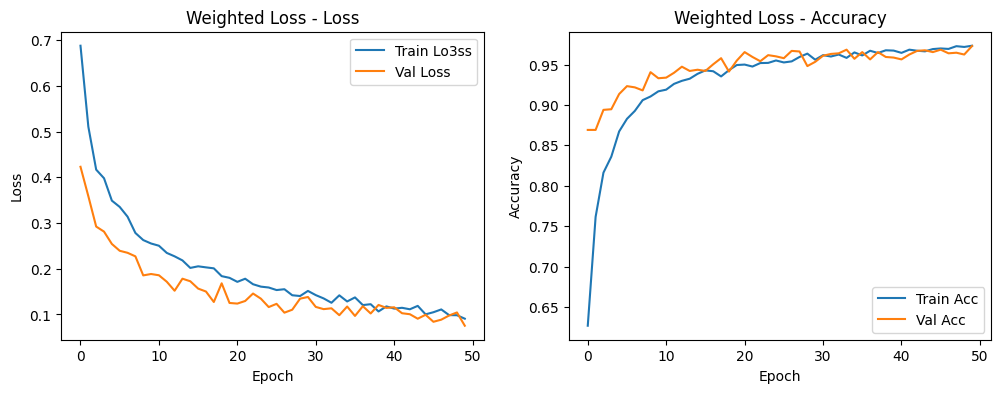

In [14]:
# Plot initial training results
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Lo3ss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Weighted Loss - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Weighted Loss - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

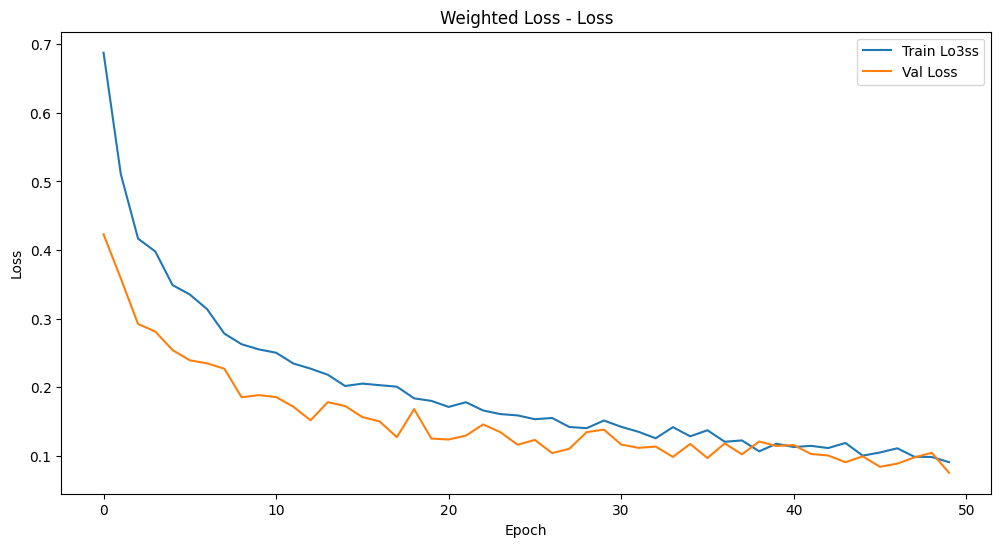

In [21]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train Lo3ss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Weighted Loss - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

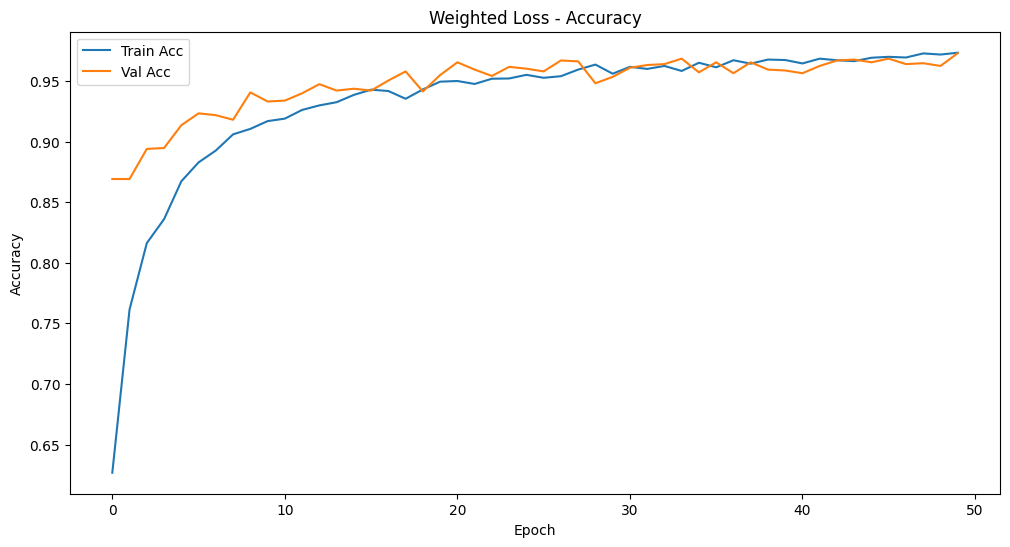

In [22]:
plt.figure(figsize=(12,6))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Weighted Loss - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [24]:
# Evaluation on the validation set
y_true, y_pred = [], []
for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype("int32").flatten())
y_true = np.array(y_true)
y_pred = np.array(y_pred)
accuracy = np.mean(y_true == y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━

When using Keras’s image_dataset_from_directory, the subdirectories are sorted alphabetically and assigned labels in that order. In your case, the two folders are named "Cancer" and "Non-Cancer":

Alphabetical Order: "Cancer" comes before "Non-Cancer."
1. Thus, images in the Cancer folder are assigned label 0.
2. Images in the Non-Cancer folder are assigned label 1.

In [25]:
from sklearn.metrics import classification_report
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Cancer", "Non-Cancer"]))

Validation Accuracy: 98.76%
Confusion Matrix:
[[ 646   25]
 [   8 1978]]
Classification Report:
              precision    recall  f1-score   support

      Cancer       0.99      0.96      0.98       671
  Non-Cancer       0.99      1.00      0.99      1986

    accuracy                           0.99      2657
   macro avg       0.99      0.98      0.98      2657
weighted avg       0.99      0.99      0.99      2657



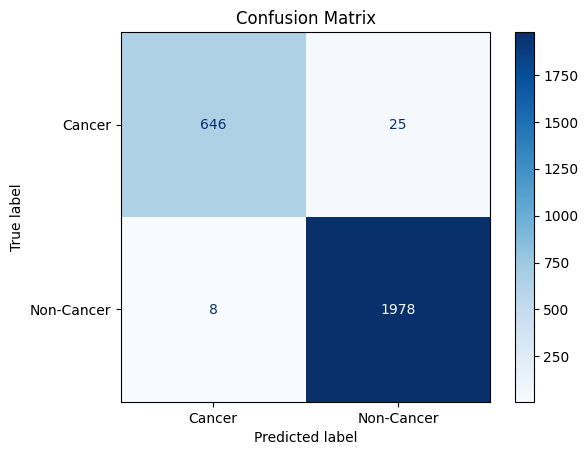

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create a display object using the computed confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cancer', 'Non-Cancer'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#save the model
model.save('last_model.keras')

### TEST ON VALIDATION DATA

In [27]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set paths
val_dir = '/kaggle/input/validation-balanced-set'
img_size = (224, 224)  # Change according to your model's input size
batch_size = 32  # Adjust batch size if necessary

In [23]:
# Load the model
model = tf.keras.models.load_model('/kaggle/input/last-model/last_model.keras')

In [28]:
# Load and preprocess the validation data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode='int',  # Binary classification, assuming 0 for cancer, 1 for non-cancer
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False  # No need to shuffle, as we're evaluating
)

# Predict on the validation data
y_true = []
y_pred = []

for images, labels in val_ds:
    # Preprocess images (if needed)
    preds = model.predict(images)
    preds = (preds > 0.5).astype('int32').flatten()  # Threshold for binary classification
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

Found 776 files belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


In [29]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Cancer', 'Non-Cancer']))

Classification Report:
              precision    recall  f1-score   support

      Cancer       1.00      0.99      1.00       388
  Non-Cancer       0.99      1.00      1.00       388

    accuracy                           1.00       776
   macro avg       1.00      1.00      1.00       776
weighted avg       1.00      1.00      1.00       776



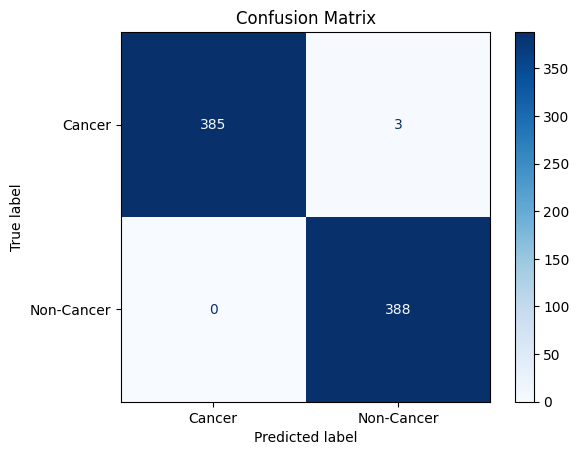

In [30]:
# Compute and display confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cancer', 'Non-Cancer'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## **EVALUATION**

In [2]:
import os
print(os.path.exists('last_model.keras')) ## best curve

True


In [ ]:
# Set the path to the new image
image_path = "../Test/Non-cancer/IMG (85).jpg" 
model = tf.keras.models.load_model('last_model.keras')

In [ ]:
import tensorflow as tf

def predict_image(model, image_path, threshold=0.5):
    """
    Loads an image from the given path, preprocesses it, and uses the model to predict.
    
    Parameters:
      model: The pre-trained Keras model.
      image_path: Path to the image file.
      threshold: Decision threshold for classification.
      
    Returns:
      A tuple (prediction, confidence) where:
        - prediction: A string "Normal" or "Cancer".
        - confidence: The confidence of the prediction as a fraction (0 to 1).
    """
    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))  # Resize to match the model's expected input size
    img = tf.keras.applications.resnet.preprocess_input(img)  # Preprocessing for ResNet
    
    # Add a batch dimension
    img = tf.expand_dims(img, axis=0)
    
    # Make prediction
    pred = model.predict(img)
    score = pred[0][0]  # Extract probability from prediction array
    
    # Determine prediction and confidence based on threshold
    if score > threshold:
        prediction = "Normal"
        confidence = score  # Confidence for Normal class
    else:
        prediction = "Cancer"
        confidence = 1 - score  # Confidence for Cancer class

    print("Prediction:", prediction)
    print("Confidence: {:.2f}%".format(confidence * 100))
    
    return prediction, confidence

In [8]:
predict_image(model, image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Prediction: Normal
Confidence: 100.00%


('Normal', np.float32(0.9999896))